In [ ]:
# import pandas as pd
# import os

# folder_path = 'BS_ca1/data/'
# files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
# files.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

# data = list()

# for filename in files:
#     if filename.endswith('.csv'):
#         data.append(pd.read_csv(os.path.join(folder_path, filename)))

# # Concatenate all dataframes into one
# data = pd.concat(data, ignore_index=True)
# data = data.drop(columns=['thisRow.t', 'notes', 'session', 'date', 'expName', 'psychopyVersion', 'frameRate', 'Unnamed: 13'])
# data.to_csv('data.csv', index=False)

In [ ]:
import pandas as pd

data = pd.read_csv('data.csv')
data

,Feature Type,Feature Number,Morph Level,Key,Response Time,participant
0,app,1,55,right,1.494435,sub1
1,app,1,88,right,0.303084,sub1
2,app,1,22,left,0.446581,sub1
3,app,1,99,right,0.223730,sub1
4,app,1,77,right,0.234538,sub1
...,...,...,...,...,...,...
1595,sha,11,55,left,0.281870,sub4
1596,sha,11,0,left,0.241668,sub4
1597,sha,11,88,right,0.252113,sub4
1598,sha,11,11,left,0.204552,sub4


In [3]:
# Convert key responses to binary: right=1, left=0
data['response'] = data['Key'].map({'right': 1, 'left': 0})

In [4]:
import numpy as np

def sigmoid(x, L ,x0, k, b):
    return L / (1 + np.exp(-k*(x-x0))) + b

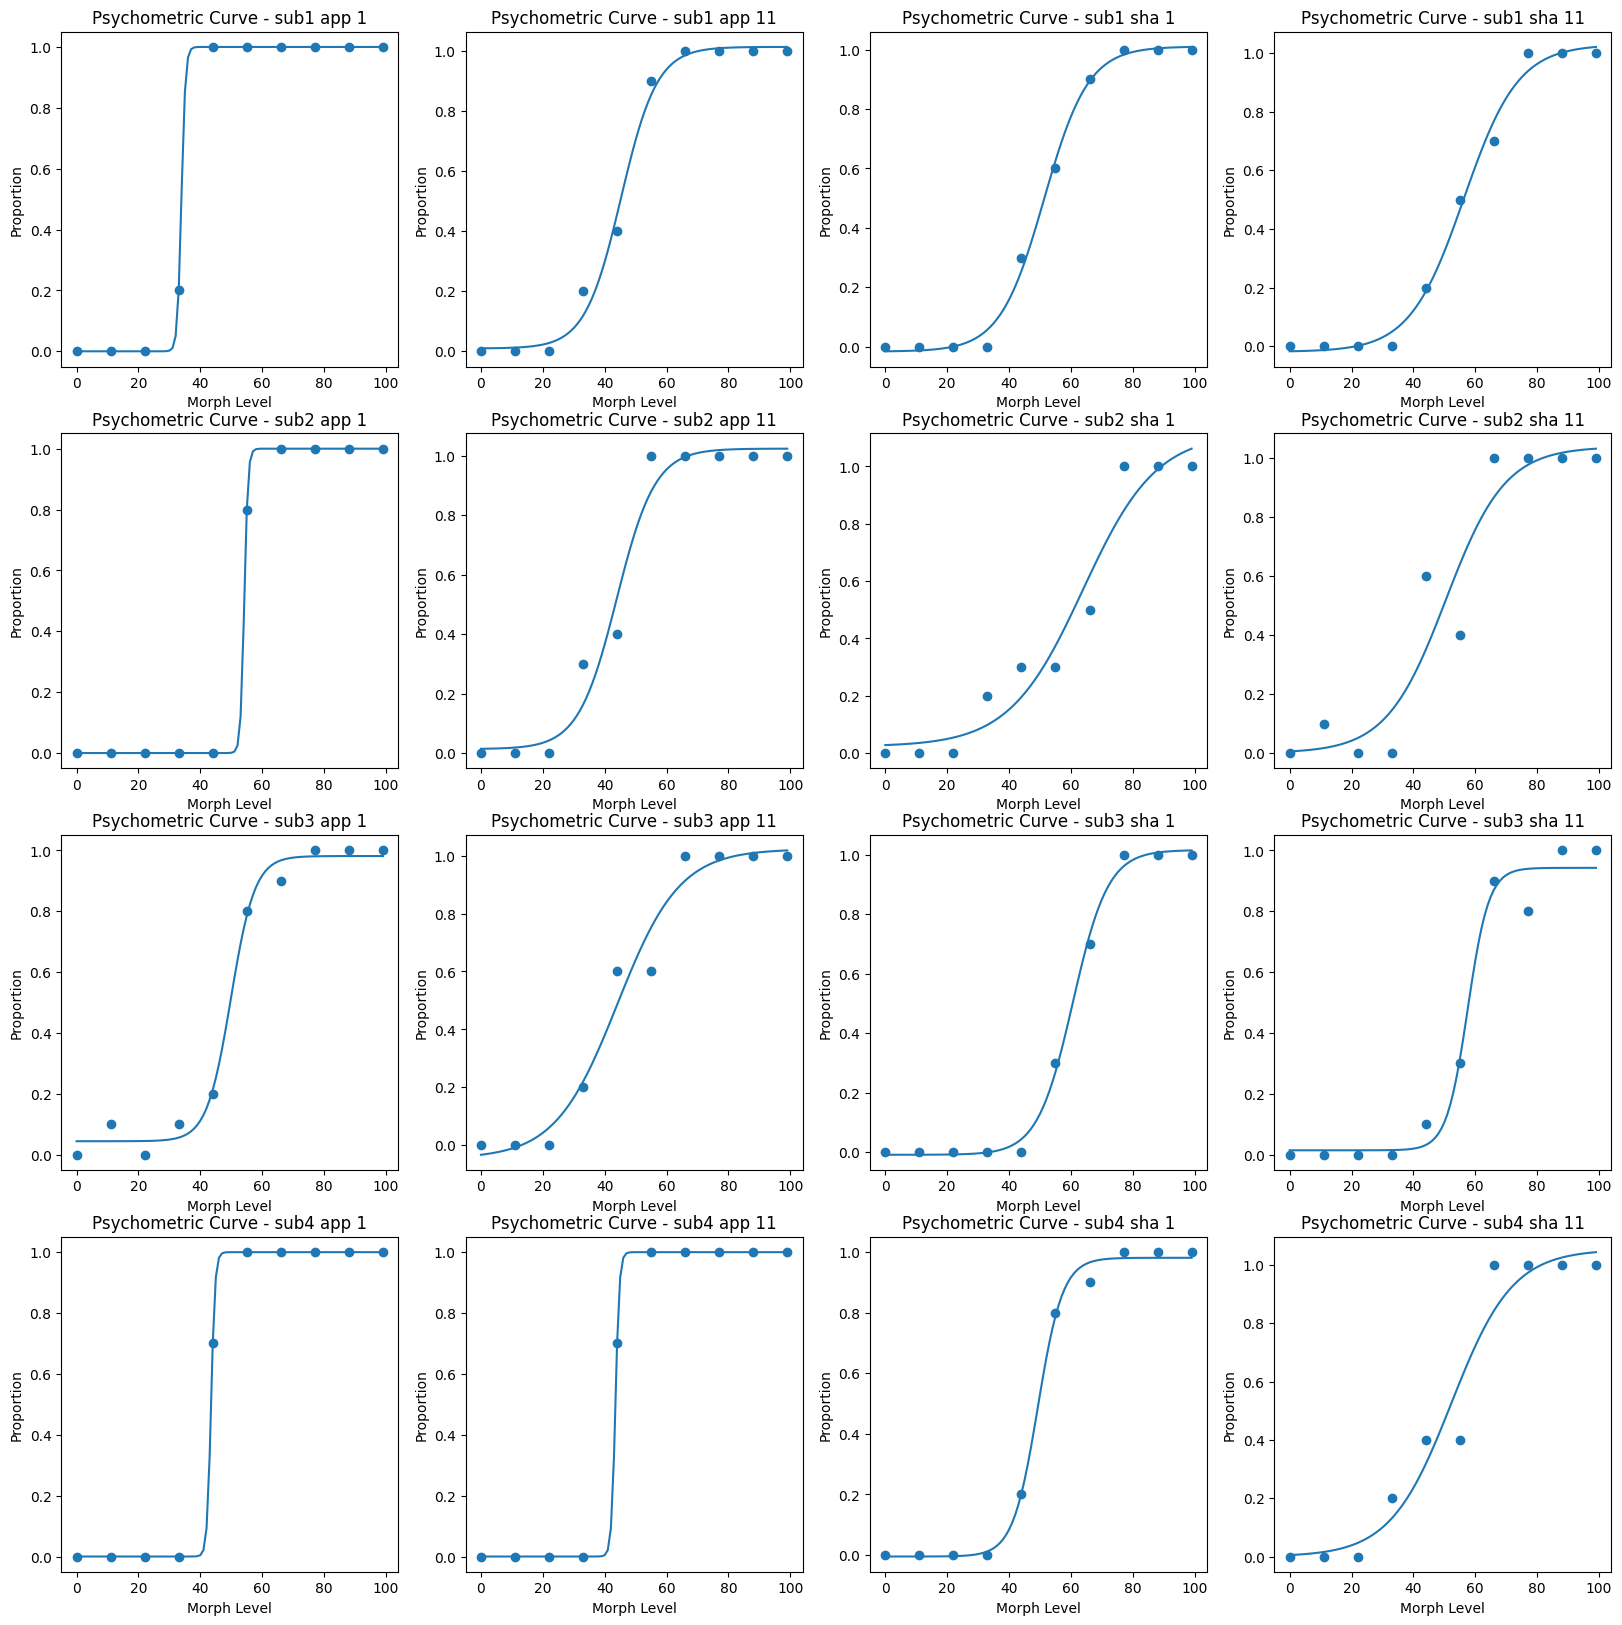

In [5]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from collections import defaultdict

num_subs = data['participant'].unique().size
plt.figure(figsize=(20, 5 * num_subs))

jnd_results = defaultdict(list)

for i, subject in enumerate(data['participant'].unique()):
    sub_data = data[data['participant'] == subject]
    jnd_results[('Subject', '')].append(subject)

    for j1, feature_type in enumerate(sub_data['Feature Type'].unique()):
        for j2, feature_number in enumerate(sub_data['Feature Number'].unique()):
            subset = sub_data[(sub_data['Feature Type'] == feature_type) & (sub_data['Feature Number'] == feature_number)]

            # Group by morph level
            grouped = subset.groupby('Morph Level')['response'].mean()
            xdata = grouped.index.values
            ydata = grouped.values

            # Initial guess for sigmoid params
            p0 = [1, 50, 0.1, 0]

            popt, _ = curve_fit(sigmoid, xdata, ydata, p0, maxfev = 10000)
            L ,x0, k, b = popt

            # Plot
            x_fit = np.linspace(min(xdata), max(xdata), 100)
            y_fit = sigmoid(x_fit, *popt)

            plt.subplot(num_subs, 4, i * 4 + j1 * 2 + j2 + 1)
            plt.scatter(xdata, ydata)
            plt.plot(x_fit, y_fit)
            plt.title(f'Psychometric Curve - {subject} {feature_type} {feature_number}')
            plt.xlabel('Morph Level')
            plt.ylabel('Proportion')

            # JND is approximately 1/k
            jnd = 1 / k
            jnd_results[(feature_type, feature_number)].append(jnd)

plt.savefig('psychometric.pdf', bbox_inches='tight')

jnd_results = pd.DataFrame(jnd_results).set_index('Subject')
jnd_results.columns.names = ['Feature Type', 'Feature Number']

In [6]:
jnd_results

Feature Type         app                   sha          
Feature Number         1         11          1        11
Subject                                                 
sub1            0.637297   5.832889   7.155413  8.755887
sub2            0.591476   6.202066  11.868594  9.591499
sub3            3.867839  10.050176   5.701514  3.422685
sub4            0.640705   0.640705   4.023748  9.891496

In [7]:
from scipy.stats import wilcoxon

app_jnds = jnd_results['app'].values.flatten()
sha_jnds = jnd_results['sha'].values.flatten()

stat, p_value = wilcoxon(app_jnds, sha_jnds, alternative='less')

print('Statistic:', stat)
print('p-value:', p_value)

Statistic: 6.0
p-value: 0.0546875


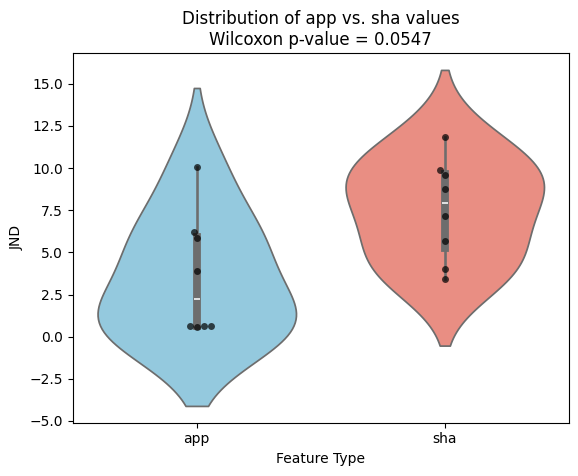

In [8]:
import seaborn as sns

sns.violinplot(jnd_results, palette=['skyblue', 'salmon'])
sns.swarmplot(jnd_results, color='black', alpha=0.7)

plt.title(f'Distribution of app vs. sha values\nWilcoxon p-value = {p_value:.4f}')
plt.xlabel('Feature Type')
plt.ylabel('JND')

plt.savefig("app_vs_sha_violin.pdf", bbox_inches="tight")